In [222]:
import pandas as pd
from graph_tool.all import *
import numpy as np
from collections import *
import heapq

In [223]:
games = pd.read_csv('games.csv')
plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
player_play = pd.read_csv('player_play.csv')

In [224]:
# Merge all info
plays_subset = plays[['gameId', 'playId', 'possessionTeam', 'expectedPoints', 'expectedPointsAdded', 'yardsGained']]
player_play = player_play.merge(plays_subset, on=['gameId', 'playId'], how='left')
player_play = player_play.merge(games[['gameId', 'week']], on='gameId', how='left')

print(player_play.head())

       gameId  playId  nflId teamAbbr  hadRushAttempt  rushingYards  \
0  2022090800      56  35472      BUF               0             0   
1  2022090800      56  42392      BUF               0             0   
2  2022090800      56  42489      BUF               0             0   
3  2022090800      56  44875      BUF               0             0   
4  2022090800      56  44985      BUF               0             0   

   hadDropback  passingYards  sackYardsAsOffense  hadPassReception  ...  \
0            0             0                   0                 0  ...   
1            0             0                   0                 0  ...   
2            0             0                   0                 1  ...   
3            0             0                   0                 0  ...   
4            0             0                   0                 0  ...   

   pressureAllowedAsBlocker  timeToPressureAllowedAsBlocker  \
0                       0.0                             NaN

In [225]:
# Determine which team to analyze: ex) Carolina Panthers
team = 'CAR'
plays = player_play[player_play['possessionTeam'] == team]
team_player_play = player_play[player_play['teamAbbr'] == team]

games = pd.concat([games[games['homeTeamAbbr'] == team], games[games['visitorTeamAbbr'] == team]], ignore_index=True)

print(games.head())

       gameId  season  week    gameDate gameTimeEastern homeTeamAbbr  \
0  2022091101    2022     1   9/11/2022        13:00:00          CAR   
1  2022092500    2022     3   9/25/2022        13:00:00          CAR   
2  2022100203    2022     4   10/2/2022        16:05:00          CAR   
3  2022100910    2022     5   10/9/2022        16:05:00          CAR   
4  2022102301    2022     7  10/23/2022        13:00:00          CAR   

  visitorTeamAbbr  homeFinalScore  visitorFinalScore  
0             CLE              24                 26  
1              NO              22                 14  
2             ARI              16                 26  
3              SF              15                 37  
4              TB              21                  3  


In [226]:
'''
Description of all Offensive Positions
QB	Quarterback	Passes, runs, leads offense
RB	Running Back	Primary rusher, may catch passes
FB	Fullback	Blocks, short yardage runs
WR	Wide Receiver	Pass catcher, runs routes
TE	Tight End	Blocks + catches passes
T / OT	Offensive Tackle	Usually split into LT (left tackle) and RT
G / OG	Offensive Guard	LG (left guard) and RG (right guard)
C	Center	Snaps ball, blocks
'''

position_map = {'QB': 'QB', 'WR': 'WR', 'TE': 'TE', 'RB': 'RB', 'FB': 'RB', 'HB': 'RB',
                'C': 'OL', 'G': 'OL', 'OG': 'OL', 'OT': 'OL', 'T': 'OL'}

players['positionGroup'] = players['position'].map(position_map).fillna('Other')
offensive_players = players[players['positionGroup'].isin(['QB', 'WR', 'TE', 'RB', 'OL'])]
print(offensive_players)

      nflId height  weight   birthDate       collegeName position  \
0     25511    6-4     225  1977-08-03          Michigan       QB   
1     29550    6-4     328  1982-01-22          Arkansas        T   
2     29851    6-2     225  1983-12-02        California       QB   
3     30842    6-6     267  1984-05-19              UCLA       TE   
4     33084    6-4     217  1985-05-17    Boston College       QB   
...     ...    ...     ...         ...               ...      ...   
1684  55151   5-10     207         NaN           Florida       RB   
1685  55157    6-4     245         NaN           Indiana       TE   
1686  55158    6-2     205         NaN  Western Illinois       WR   
1687  55168    6-1     195         NaN      Ferris State       WR   
1688  55169   5-11     190         NaN           Arizona       WR   

            displayName positionGroup  
0             Tom Brady            QB  
1          Jason Peters            OL  
2         Aaron Rodgers            QB  
3        Ma

In [227]:
player_stats = defaultdict(lambda: [0, 0])
co_occurrence = defaultdict(lambda: defaultdict(lambda: [0, 0]))
gameIds = team_player_play['gameId'].unique()

# analyze game play for each match, and total combined EPA, Plays when both players were on the field for the same play.
for play in gameIds:
    match = plays[plays['gameId'] == play]
    for i, j in match.iterrows():
        x_id = j['playId']
        epa = j['expectedPointsAdded']
        all_players_invovled = team_player_play[
            (team_player_play['gameId'] == play) &
            (team_player_play['playId'] == x_id)
        ]

        offensive_ids = all_players_invovled['nflId'].dropna().unique()
        for p_id in offensive_ids:
            player_stats[p_id][0] += epa
            player_stats[p_id][1] += 1

        for x, p1_id in enumerate(offensive_ids):
            for p2_id in offensive_ids[x+1:]:
                co_occurrence[p1_id][p2_id][0] += epa
                co_occurrence[p1_id][p2_id][1] += 1
                co_occurrence[p2_id][p1_id][0] += epa
                co_occurrence[p2_id][p1_id][1] += 1


In [228]:
# Basic structure of the player network graph
gx = Graph(directed=False)

# Each node contains player info
player_id = gx.new_vertex_property("int")
player_name = gx.new_vertex_property('string')
player_position = gx.new_vertex_property('string')
player_epa = gx.new_vertex_property('double')
player_plays = gx.new_vertex_property('int')
player_centrality = gx.new_vertex_property('double')

# Edges represents the relationship between players who appear on the field together
pair_plays = gx.new_edge_property("int")
pair_epa = gx.new_edge_property("double")

In [229]:
adj_mat = {}
for s_id, stats in player_stats.items():
    if s_id is not None and s_id not in adj_mat:
        v = gx.add_vertex()
        adj_mat[s_id] = v

        player_info = players[players['nflId'] == s_id]
        if not player_info.empty:
            player_name[v] = player_info.iloc[0]['displayName']
            player_position[v] = player_info.iloc[0]['position']
        else:
            player_name[v] = f"Player {s_id}"
            player_position[v] = "NaN"

        player_id[v] = int(s_id)
        if stats[1] > 0:
            player_epa[v] = stats[0] / stats[1]
        else:
            player_epa[v] = 0
        player_plays[v] = stats[1]

for p1_id, connections in co_occurrence.items():
    for p2_id, stats in connections.items():
        if p1_id in adj_mat and p2_id in adj_mat and stats[1] > 0:
            src, tgt = adj_mat[p1_id], adj_mat[p2_id]
            edge_exists = False
            for e in src.out_edges():
                if e.target() == tgt:
                    edge_exists = True
                    break

            if not edge_exists:
                e = gx.add_edge(src, tgt)
                pair_plays[e] = stats[1]
                pair_epa[e] = stats[0] / stats[1]

In [230]:
gx.vertex_properties["name"] = player_name
gx.vertex_properties["id"] = player_id
gx.vertex_properties["position"] = player_position
gx.vertex_properties["epa"] = player_epa
gx.vertex_properties["plays"] = player_plays
gx.edge_properties["plays"] = pair_plays
gx.edge_properties["epa"] = pair_epa

In [231]:
# calculate eigenvector centrality
e = eigenvector(gx)
gx.vp.eigenvector = e[1]
player_centrality = e[1]
top_players = [] # best 5 for each team

for v in gx.vertices():
    heapq.heappush(top_players, (player_centrality[v], v))
    if len(top_players) > 5:
        heapq.heappop(top_players)

top_players.sort(reverse=True)
for score, v in top_players:
    print(f"{gx.vp.name[v]}: pos=({gx.vp.position[v]}), centrality={score:.4f}, EPA/play={gx.vp.epa[v]:.4f}")


Brady Christensen: pos=(T), centrality=0.2251, EPA/play=-0.1240
Ikem Ekwonu: pos=(T), centrality=0.2251, EPA/play=-0.1240
Austin Corbett: pos=(G), centrality=0.2251, EPA/play=-0.1240
D.J. Moore: pos=(WR), centrality=0.2251, EPA/play=-0.1259
Taylor Moton: pos=(T), centrality=0.2251, EPA/play=-0.1240


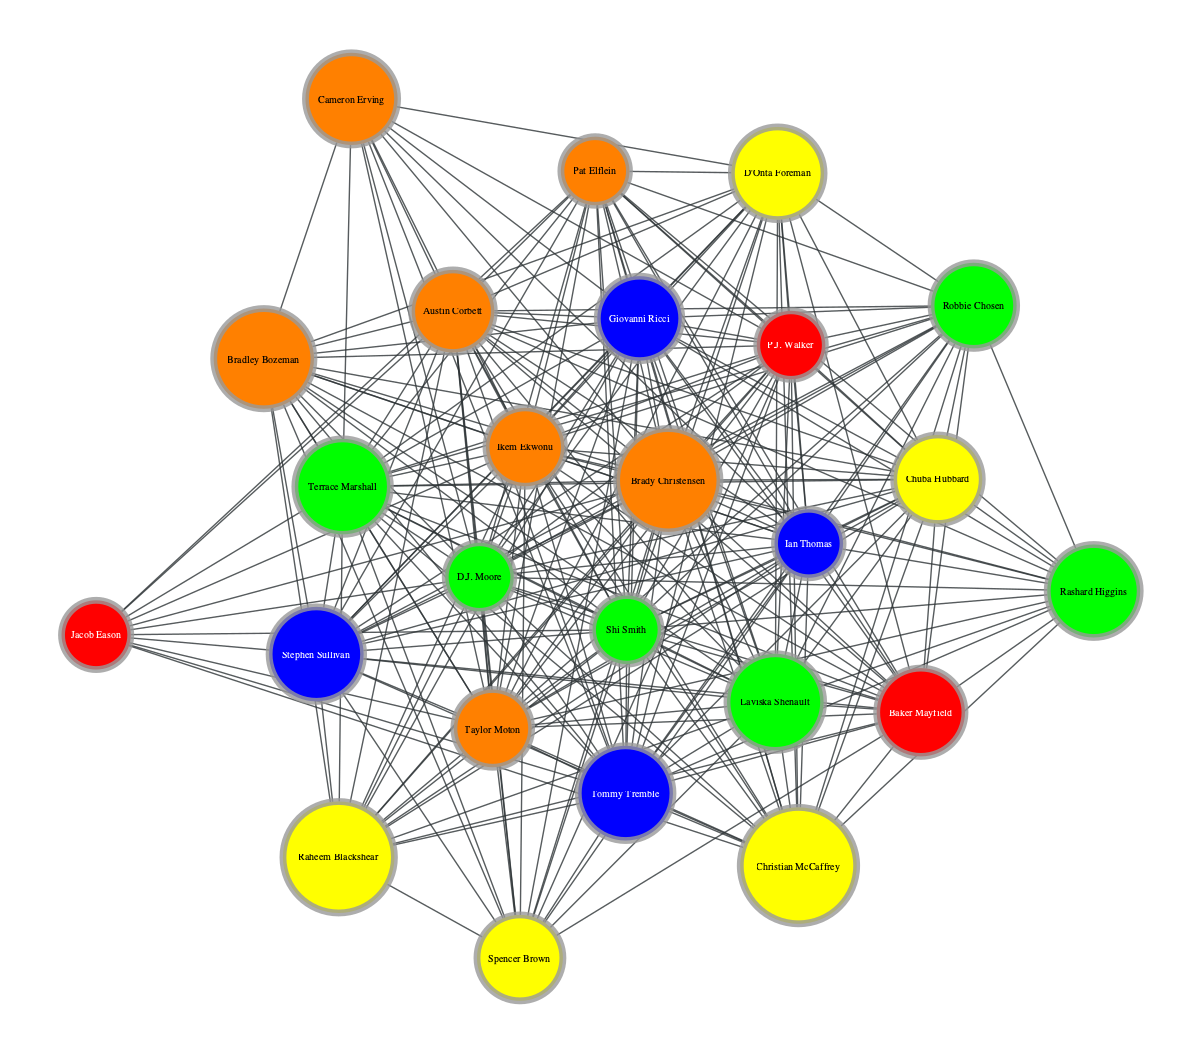

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15fccd490, at 0x17f501160>

In [232]:
pos = sfdp_layout(gx)
colors = {'QB': [1.0, 0.0, 0.0, 1.0],
          'WR': [0.0, 1.0, 0.0, 1.0],
          'TE': [0.0, 0.0, 1.0, 1.0],
          'RB': [1.0, 1.0, 0.0, 1.0],
          'FB': [1.0, 1.0, 0.0, 1.0],
          'HB': [1.0, 1.0, 0.0, 1.0],
          'C': [1.0, 0.5, 0.0, 1.0],
          'G': [1.0, 0.5, 0.0, 1.0],
          'OG': [1.0, 0.5, 0.0, 1.0],
          'OT': [1.0, 0.5, 0.0, 1.0],
          'T': [1.0, 0.5, 0.0, 1.0]}
# QB: Red, WR: Green, TE: Blue, RB: Yellow, OL: Orange
c = gx.new_vertex_property("vector<double>")
for v in gx.vertices():
    c[v] = colors.get(player_position[v], [0.0, 0.0, 0.0, 1.0])

graph_draw(gx, pos=pos, vertex_text=player_name, vertex_fill_color=c, vertex_font_size=5, edge_pen_width=0.7)

In [233]:
sort_players = sorted([(v, player_centrality[v], player_epa[v]) for v in gx.vertices()],
                      key=lambda x: x[1], reverse=True)
unsung_hero = []
for v, centrality, epa in sort_players:
    if v not in top_players:
        unsung_hero.append({
            'name': player_name[v],
            'position': player_position[v],
            'centrality': centrality,
            'epa': epa
        })

unsung_hero.sort(key=lambda x: (x['centrality'], x['epa']), reverse=True)
player = unsung_hero[0]
print("Unsung Hero: ")
print(f"{player['name']} ({player['position']}): Centrality: {player['centrality']:.4f}, EPA: {player['epa']:.4f}")

Unsung Hero: 
Brady Christensen (T): Centrality: 0.2251, EPA: -0.1240


In [234]:
# Helpful info for debugging purposes
#
# for v in gx.vertices():
#     node_info = {
#         'id': gx.vp.id[v],
#         'name': gx.vp.name[v],
#         'position': gx.vp.position[v],
#         'epa': gx.vp.epa[v],
#         'plays': gx.vp.plays[v],
#         'centrality': gx.vp.eigenvector[v]
#     }
#     print(node_info)